## Model training and selection

#### 1. Recap

##### Goal

Recalling what we're demanded:
1. Using the from year 2014 to the 31st of August 2017
2. Forecasting the first full week of September of 2017 (monday the 4th to Sunday the 10th)

##### Previous data observations
* High seasonality accross the year:
* No bike activity during the winter months (December to March)
* Weekly seasonality

#### 2. Iteration in model selection
We've explored in this notebook two potential routes for model algorithms:
1. SARIMA
2. Prophet <br>

The latter proving to overcome quite effortlesstly the multiple seasonalities from the data.

#### 3. Forecast of member trips

#### 4. Improvements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
import time
import itertools
from datetime import datetime
# SARIMA libs
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# FB Prophet
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import plot_plotly, plot_components_plotly
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

### Prepping the data for ingestion

In [2]:
df = pd.read_csv('daily_trips.csv',index_col='date')
df.index = pd.DatetimeIndex(df.index)

We complete the missing dates as our forecasting models will rely on regular intervals. We logically fill the number of trips of these missing days to 0.

In [3]:
idx = pd.date_range('01-01-2014', '09-11-2017')
df = df.reindex(idx, fill_value=0)

# 2. Iteration in model selection

### SARIMA
An important factor is SARIMA is determining the seasonality parameter. We know from our observed data we have yearly and weekly seasonalities in our data, although the later being pretty weak. We thus focus on the yearly seasonality. <br>
Another challenge arises from the void winter months, which could cause issue for ARIMA-based models. We create a secondary, conservative dataset, where we keep only the months of May to September for the predictions (seasonality of 153 days). As we're looking to predict the early week of Septemebr in 2017, we decide to simply neglect the months of October and November. We also drop the month of April (half full) for simplicity and the small effect the number of trips in April will have in our prediction goal for September (see ACF plots below).

In [4]:
data_sarima = df[df.index < datetime.strptime('2017-09-01', '%Y-%m-%d')].copy()
data_nowinter = df[(df.index < datetime.strptime('2017-09-01', '%Y-%m-%d')) & (df.index.month.isin(range(5,10)))].copy()

#### Testing seasonality, stationarity and parameter tuning
We test our assumptions of seasonality in both datasets by verifying if the resulting differenced data is stationary. From the plots below, we see the autocorrelation quickly drop to 0 and remain close to 0. We further confirm our stationary hypothesis in both datasets with the ADF hypothesis test (both p values near 0). We therefore can validate the respective seasonality of both datasets (365 and 153 days respectively), as well as confirming we will not need to use the integrated form in the ARIMA model (**d=0, D=1, m={365,153}**). 

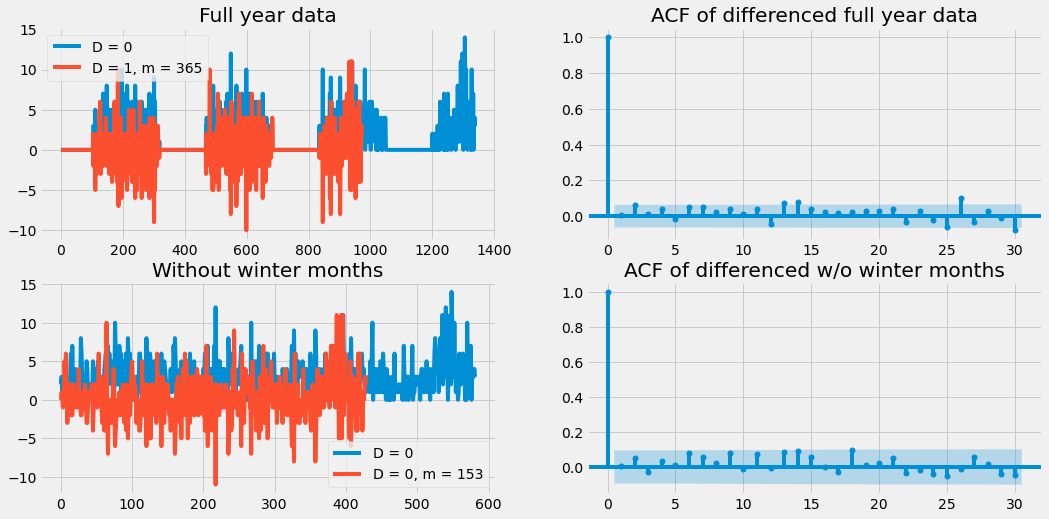

In [5]:
# ACF plots of the seasonal differentiated data
D_data_sarima = data_sarima.trips.diff(365).dropna().values
D_data_nowinter = data_nowinter.trips.diff(153).dropna().values

# Full year data
fig, axes = plt.subplots(2, 2, figsize = (16,8));
axes[0, 0].plot(data_sarima.trips.values, label='D = 0');
axes[0, 0].plot(D_data_sarima, label='D = 1, m = 365');
axes[0, 0].legend()
axes[0, 0].set_title('Full year data');
plot_acf(D_data_sarima, lags=30, ax=axes[0, 1]);
axes[0, 1].set_title('ACF of differenced full year data');

# Without winter months
axes[1, 0].plot(data_nowinter.trips.values, label='D = 0');
axes[1, 0].plot(D_data_nowinter, label='D = 0, m = 153');
axes[1, 0].legend()
axes[1, 0].set_title('Without winter months');
plot_acf(D_data_nowinter, lags=30, ax=axes[1, 1]);
axes[1, 1].set_title('ACF of differenced w/o winter months');

We've plotted below the ACF and PACF of the full year data and data without winter months. By removing the winter months, we greatly remove autocorrelation within the data. Hence, **we will continue with the data without winter months (WWM)**.

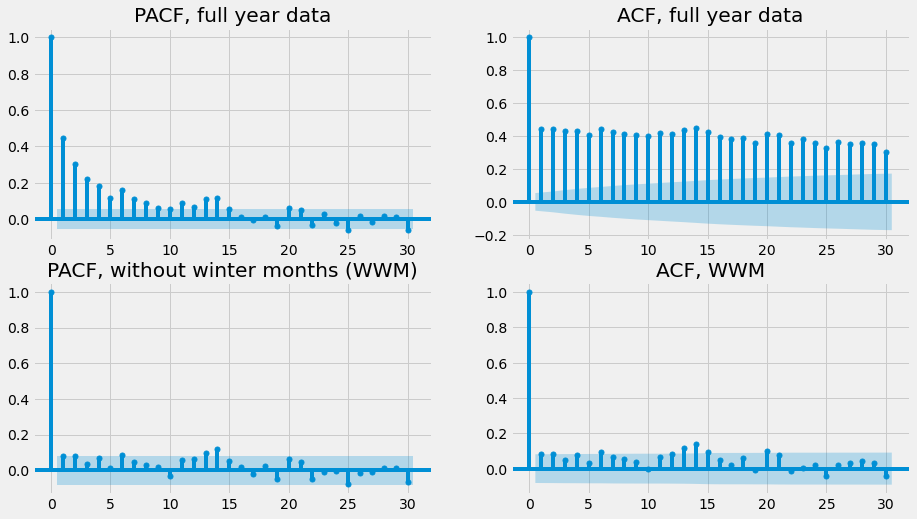

In [6]:
# Full year data
fig, axes = plt.subplots(2, 2, figsize = (14,8));
plot_pacf(data_sarima.trips, lags=30, ax=axes[0,0]);
axes[0,0].set_title('PACF, full year data');
plot_acf(data_sarima.trips, lags=30, ax=axes[0,1]);
axes[0,1].set_title('ACF, full year data');

# Without winter months
plot_pacf(data_nowinter.trips, lags=30, ax=axes[1,0]);
axes[1,0].set_title('PACF, without winter months (WWM)');
plot_acf(data_nowinter.trips, lags=30, ax=axes[1,1]);
axes[1,1].set_title('ACF, WWM');

We finish our investigation by plotting the ACF and PACF of both the WWM data and differenced WWM data to help us preselected suitable ranges of SARIMA parameters (p, q, P, Q). For the differenced WWM, both ACF and PACF show close to 0 values. We can easily just set **P and Q to 0** in this case. In the WWM data, a few lags exhibit potential correlations (e.g lags at 6 and 13-14 days), we'll thus explore a few values of **p and q ranging from 0 to 2.**

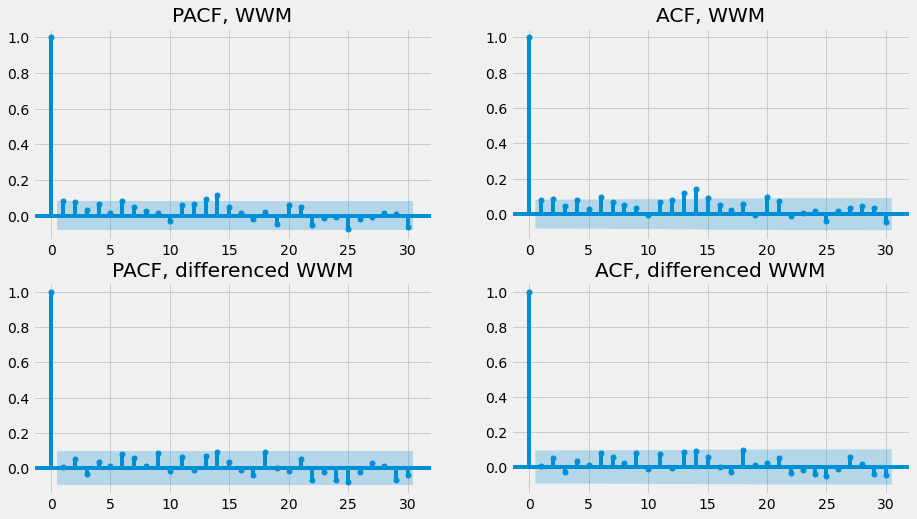

In [7]:
# WWM
fig, axes = plt.subplots(2, 2, figsize = (14,8));
plot_pacf(data_nowinter.trips, lags=30, ax=axes[0,0]);
axes[0,0].set_title('PACF, WWM');
plot_acf(data_nowinter.trips, lags=30, ax=axes[0,1]);
axes[0,1].set_title('ACF, WWM');

# Differenced, WWM
plot_pacf(D_data_nowinter, lags=30, ax=axes[1,0]);
axes[1,0].set_title('PACF, differenced WWM');
plot_acf(D_data_nowinter, lags=30, ax=axes[1,1]);
axes[1,1].set_title('ACF, differenced WWM');

#### Finding the best parameters for the SARIMA model
We run different SARIMA models with various conbinations of parameters. 
* $p, q \in [0,2]$
* P = Q = d = 0
* D = 1, m = 153<br >


AIC is selected as our criterion for best model selection.

In [8]:
# Define the p, q parameters to take any value between 0 and 2
p = q = range(0, 2)
d = range(0, 1) # d is known is here and set to 0

# Generate all different combinations of p and q
simple_pdq = list(itertools.product(p, d, q))

# The seasonal parameters have been set by our obsevation. P = Q = 0, D = 1, m = 153
seasonal_pdq = [[0,1,0,153]]

print('Parameter combinations for SARIMA...')

warnings.filterwarnings("ignore") # specify to ignore warning messages

min_aic = 10000
best_simple_pdq = []
best_seasonal_pdq = []

start_time = time.time()

for param in simple_pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(data_nowinter['trips'],
                                            order=param,
                                            seasonal_order = param_seasonal
                                            )

            results = mod.fit()

            print('ARIMA{}x{} - AIC:{} - BIC:{}'.format(param, param_seasonal, results.aic, results.bic))
            
            if results.aic < min_aic:
                min_aic = results.aic
                best_simple_pdq = param
                best_seasonal_pdq = param_seasonal
                
        except Exception as e:
            print(e)
            continue

end_time = time.time()
elaspsed_time = int((end_time - start_time))
print("Finished iterating in: " + str(int(elaspsed_time)) + " seconds")

Parameter combinations for SARIMA...
ARIMA(0, 0, 0)x[0, 1, 0, 153] - AIC:2156.80433754952 - BIC:2160.865794468448
ARIMA(0, 0, 1)x[0, 1, 0, 153] - AIC:2158.7769812779106 - BIC:2166.899895115767
ARIMA(1, 0, 0)x[0, 1, 0, 153] - AIC:2158.774176113374 - BIC:2166.89708995123
ARIMA(1, 0, 1)x[0, 1, 0, 153] - AIC:2160.22299029617 - BIC:2172.407361052954
Finished iterating in: 45 seconds


In [9]:
print("Best AIC : ", min_aic)
print("Best simple parameters: ", best_simple_pdq)
print("Best seasonal parameters: ", best_seasonal_pdq)

Best AIC :  2156.80433754952
Best simple parameters:  (0, 0, 0)
Best seasonal parameters:  [0, 1, 0, 153]


We do a quick high level check of the performance of the best model. The p-value for the variance in our error is very significative, and our variance value is high (8.9, i.e. a standard error of roughly 3). Other notable results here:
* The p-value of the Ljung — Box test for the first lag is high, meaning there **is likely information that remains in the residuals**. Something that would need improvements upon. It is possible that the model fails to see the weekly seasonality patterns, even though the best model did remove the AR and MA parameters.
* The Jarque bera test is close to zero, the data is normally distributed.
* The p-value of the test for Heteroskedasticity is also close to zero, meaning the variance of the error term is constant across all values of the independent variables.

In [10]:
best_sarima_model = SARIMAX(data_nowinter['trips'], order=(0, 0, 0), seasonal_order=(0, 1, 0, 153)).fit()
print(best_sarima_model.summary())

                                 SARIMAX Results                                 
Dep. Variable:                     trips   No. Observations:                  582
Model:             SARIMAX(0, 1, 0, 153)   Log Likelihood               -1077.402
Date:                   Fri, 20 May 2022   AIC                           2156.804
Time:                           14:32:30   BIC                           2160.866
Sample:                                0   HQIC                          2158.408
                                   - 582                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         8.8904      0.463     19.216      0.000       7.984       9.797
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                39.32
Prob(Q):               

The best model disregards any Moving Average or Auto Regression for its predictions, hence is purely using the value of the previous year as a forecast. In order words, as $p = q = d = P = Q = 0$, then $y_t = y_{t-153}$.

<br />
We now use this model to forecast the 4th to the 10th of September 2017 and compute the MAE and we obtain 2.98 (which is very close to the square root of the variance of the errors we got from training the entire model).

In [11]:
forecast_values = best_sarima_model.forecast(steps = 10)

In [12]:
y_true = df[df.index.isin(pd.date_range("2017-09-04", "2021-09-10"))]

In [13]:
y_true = df[df.index.isin(pd.date_range("2017-09-04", "2021-09-10"))]['trips'].values
y_pred = forecast_values.tail(8).values
mae = mean_absolute_error(y_true, y_pred)
print("Mean absolute error of SARIMA model for the time period between the 4th and 10th of September: %.2f" % mae)

Mean absolute error of SARIMA model for the time period between the 4th and 10th of September: 2.88


<br />
<br />

## Prophet

In [14]:
# data prep for Prophet library. The x (date) column is renamed ds, the predicted variable y (number of trips).
data_prophet = df[df.index < datetime.strptime('2017-08-31', '%Y-%m-%d')].copy()
data_prophet.rename(columns={'trips':'y'},inplace=True)
data_prophet['ds'] = data_prophet.index

### First iteration
We make a first quick iteration with the Prophet python library to get a first sense of the performance of the model. Following our preliminary data observation, we impose the libraries default weekly and yearly seasonalities. We also leave the linear growth option to see how Prophet can use it changepoints to match potential trends across the data we could've missed.

In [15]:
model = Prophet( 
    growth='linear',
    weekly_seasonality=True, 
    yearly_seasonality=True, 
    daily_seasonality=False
);

model.fit(data_prophet);

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [16]:
future = model.make_future_dataframe(periods= 11, freq='d')
forecast = model.predict(future)
forecast.tail(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1346,2017-09-08,1.668297,1.128610,5.225694,1.668297,1.668297,1.588439,1.588439,1.588439,0.106643,0.106643,0.106643,1.481797,1.481797,1.481797,0.0,0.0,0.0,3.256736
1347,2017-09-09,1.668739,1.059906,5.133193,1.668739,1.668739,1.386393,1.386393,1.386393,-0.073733,-0.073733,-0.073733,1.460126,1.460126,1.460126,0.0,0.0,0.0,3.055132
1348,2017-09-10,1.669181,0.952511,5.167253,1.669181,1.669181,1.459729,1.459729,1.459729,0.023337,0.023337,0.023337,1.436392,1.436392,1.436392,0.0,0.0,0.0,3.128910


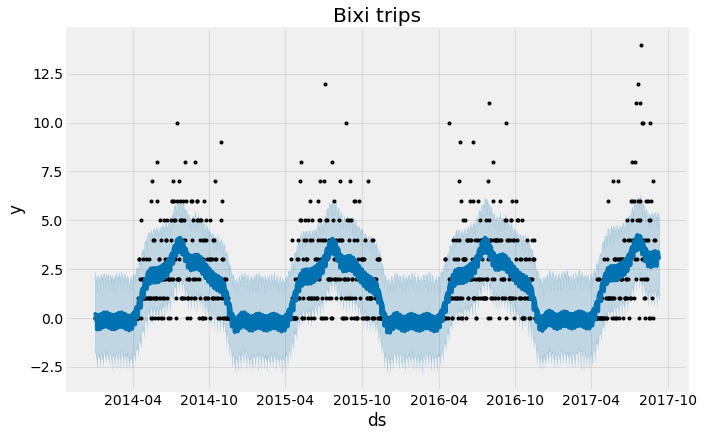

In [17]:
# Plot resulting graph to get an overview of the predictions
model.plot(forecast);
plt.title('Bixi trips')
plt.show()

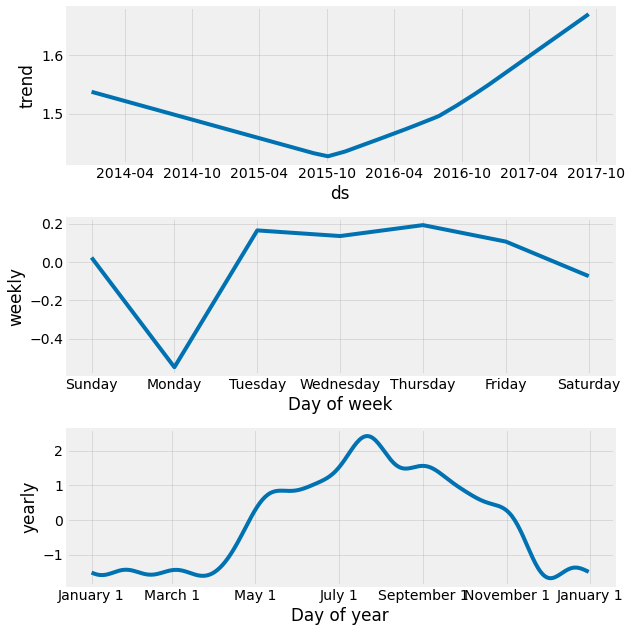

In [18]:
# overview of the key components of our Prophet model: global trend and weekly & yearly seasonalities
model.plot_components(forecast);

Not bad for a first pass. The model is pretty good at capturing both the weekly and yearly seasonality observed in our EDA. However, it seems the model is trying to impose some weirdly shaped trend across the years. We can help the model with our *a priori* knowledge that there shouldn't be any trend of the sort.

### Second iteration : removing trends
We re-run our Prophet model by simply forcing no trends in the algorithm (**growth='flat'**).

In [19]:
model = Prophet( 
    growth='flat',
    weekly_seasonality=True, 
    yearly_seasonality=True, 
    daily_seasonality=False
);

model.fit(data_prophet);

In [20]:
future = model.make_future_dataframe(periods= 11, freq='d')
forecast = model.predict(future)
forecast.tail(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1346,2017-09-08,1.5049,1.084664,5.030523,1.5049,1.5049,1.567396,1.567396,1.567396,0.106438,0.106438,0.106438,1.460958,1.460958,1.460958,0.0,0.0,0.0,3.072296
1347,2017-09-09,1.5049,0.888740,4.865024,1.5049,1.5049,1.363658,1.363658,1.363658,-0.073868,-0.073868,-0.073868,1.437527,1.437527,1.437527,0.0,0.0,0.0,2.868558
1348,2017-09-10,1.5049,1.117614,4.958637,1.5049,1.5049,1.435530,1.435530,1.435530,0.023304,0.023304,0.023304,1.412226,1.412226,1.412226,0.0,0.0,0.0,2.940430


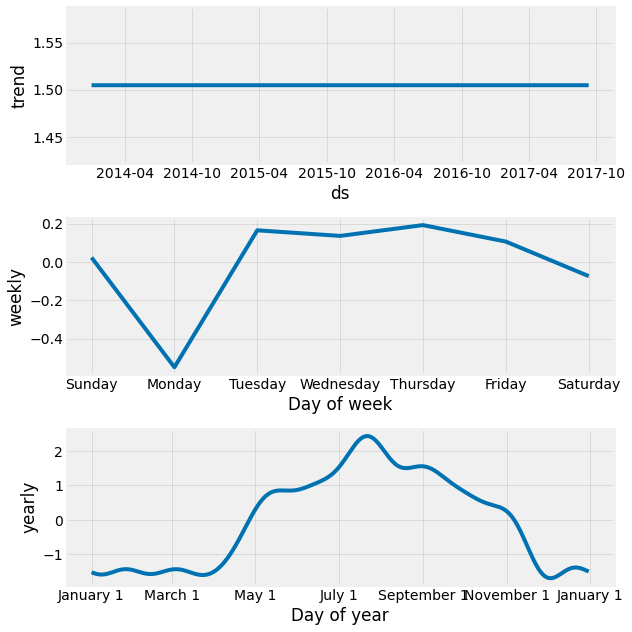

In [21]:
# overview of the key components of our Prophet model: global trend and weekly & yearly seasonalities
model.plot_components(forecast);

In [22]:
september_forecast = pd.merge(df, forecast, how='right', left_index=True,right_on='ds').tail(10)[['ds','trips','yhat','yhat_lower','yhat_upper']]
september_forecast = september_forecast[september_forecast['ds'].isin(pd.date_range("2017-09-04", "2021-09-10"))]
september_forecast

,ds,trips,yhat,yhat_lower,yhat_upper
1342,2017-09-04,0,2.486583,0.417347,4.471745
1343,2017-09-05,6,3.187806,1.200398,5.198439
1344,2017-09-06,0,3.142226,1.208484,5.085353
1345,2017-09-07,2,3.179650,1.168126,5.088285
1346,2017-09-08,3,3.072296,1.084664,5.030523
1347,2017-09-09,5,2.868558,0.888740,4.865024
1348,2017-09-10,1,2.940430,1.117614,4.958637


In [23]:
y_true = september_forecast['trips'].values
y_pred = september_forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print("Mean absolute error for the time period between the 4th and 10th of September: %.2f" % mae)

Mean absolute error for the time period between the 4th and 10th of September: 1.97


The mean absolute error will tell us, each day, the average expected error made by our predictor. In the case, the model trails around an error of 2 trips each day for that week of September between Mont-Royal and Berri-UQAM. We highlight these results in a final plot below of the actual number of trips vs our predictions during the first days of September. <br />

**The Prophet is also chosen over the SARIMA, for the accuracy and speed of training and evaluating the model.**

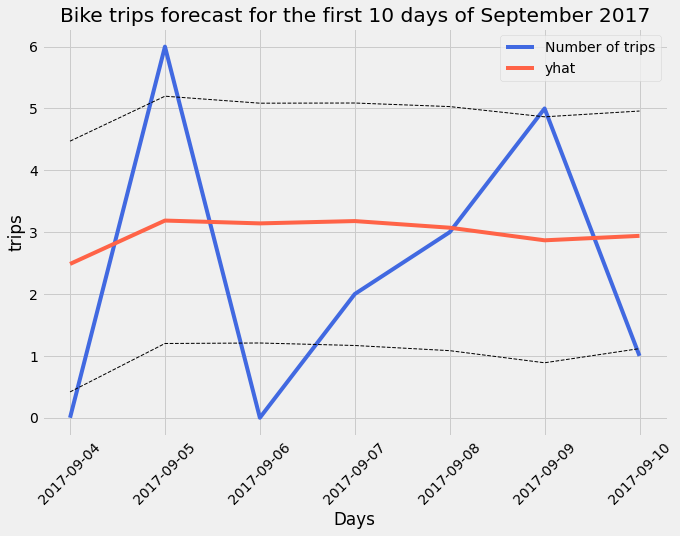

In [24]:
plt.figure(figsize=((10,7)))
plt.title("Bike trips forecast for the first 10 days of September 2017")
sns.lineplot(data=september_forecast, x='ds', y='trips', color='RoyalBlue');
sns.lineplot(data=september_forecast, x='ds', y='yhat', color='tomato');
sns.lineplot(data=september_forecast, x='ds', y='yhat_lower', color='black', linewidth=1, linestyle='--');
sns.lineplot(data=september_forecast, x='ds', y='yhat_upper', color='black', linewidth=1, linestyle='--');
plt.legend(['Number of trips','yhat']);
plt.xticks(rotation=45);
plt.xlabel('Days');
#ax.set_xticklabels(ax.get_xticklabels(), rotation = 0);

### Cross-validation
We eventually do a CV on our final model to ensure there isn't any issue of overfitting. We do the cross-validation on the active months of 2017. We notice that the overall *mae* is close to what we have observe in our future forecast of September. We quickly validate any over fitting done in this way.

In [25]:
df_cv = cross_validation(model, initial = "1200 days", horizon='60 days', parallel="processes")
df_p = performance_metrics(df_cv, rolling_window=1)
print(df_p)

INFO:fbprophet:Making 3 forecasts with cutoffs between 2017-05-02 00:00:00 and 2017-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fceb13ae430>
INFO:fbprophet:Skipping MAPE because y close to 0


  horizon      mse      rmse       mae     mdape  coverage
0 60 days  7.90138  2.810939  1.984621  0.460592  0.594444


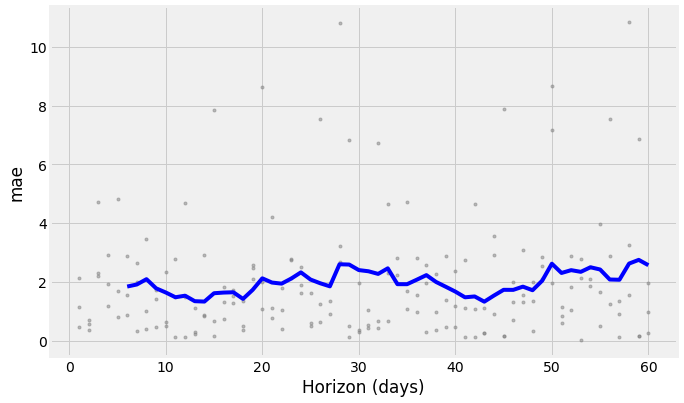

In [26]:
fig = plot_cross_validation_metric(df_cv, metric='mae')

<br />
<br />
<br />

# 3. Forecast of member trips
We run the same Prophet model steps as for all bike trips for the members only (from EDA, that account for roughly 80% of all trips). <br />

We obtain an MAE of 1.46 across the validation data of 2017, and of 1.55 for the week of September (4th to the 10th). **The MAE is smaller for the member trips than it is for all the trips considered**. A potential conclusion to this would be that **non-members trips are more volatile and harder to predict**. This makes sense as well business-wise, as non-members are less predictability going to decide to go through the process of paying and unlocking a bike. Their decision of using a bike could come from unforeseen events (metro on strike, Uber unavailable...) and add on to the error of models like the ones we used here that solely use past trips data.


In [27]:
# data prep for Prophet library. The x (date) column is renamed ds, the predicted variable y (number of trips).
data_member = df[df.index < datetime.strptime('2017-08-31', '%Y-%m-%d')].copy()
data_member.rename(columns={'member_trips':'y'},inplace=True)
data_member['ds'] = data_member.index

model_member = Prophet( 
    growth='flat',
    weekly_seasonality=True, 
    yearly_seasonality=True, 
    daily_seasonality=False
);

model_member.fit(data_member);

In [28]:
future_member = model_member.make_future_dataframe(periods= 11, freq='d')
forecast_member = model_member.predict(future)

september_forecast_member = pd.merge(df, forecast_member, how='right', left_index=True,right_on='ds').tail(10)[['ds','member_trips','yhat','yhat_lower','yhat_upper']]
september_forecast_member = september_forecast_member[september_forecast_member['ds'].isin(pd.date_range("2017-09-04", "2021-09-10"))]
y_true = september_forecast_member['member_trips'].values
y_pred = september_forecast_member['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print("Mean absolute error for the time period between the 4th and 10th of September: %.2f" % mae)

Mean absolute error for the time period between the 4th and 10th of September: 1.55


In [29]:
df_cv = cross_validation(model_member, initial = "1200 days", horizon='60 days', parallel="processes")
df_p = performance_metrics(df_cv, rolling_window=1)
print(df_p)

INFO:fbprophet:Making 3 forecasts with cutoffs between 2017-05-02 00:00:00 and 2017-07-01 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcd85fab7f0>
INFO:fbprophet:Skipping MAPE because y close to 0


  horizon       mse      rmse       mae     mdape  coverage
0 60 days  3.727712  1.930728  1.464667  0.459447      0.65


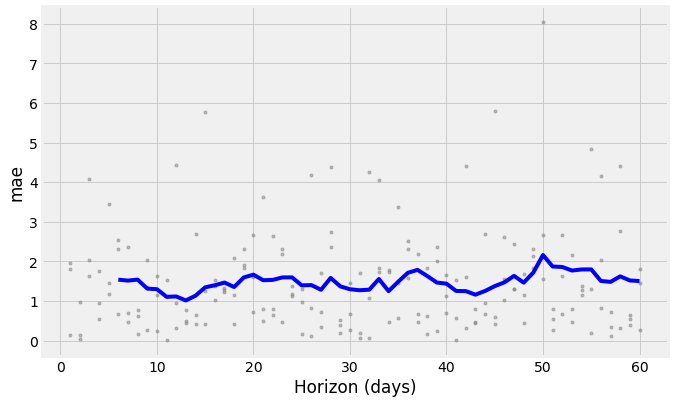

In [30]:
fig = plot_cross_validation_metric(df_cv, metric='mae')

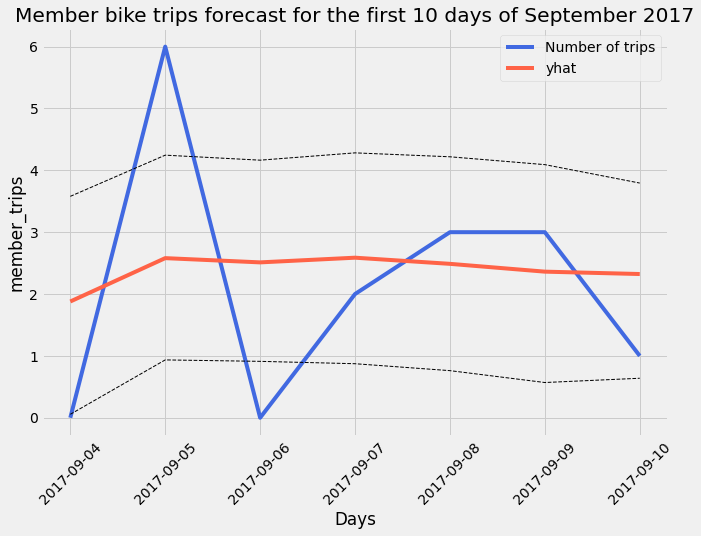

In [31]:
plt.figure(figsize=((10,7)))
plt.title("Member bike trips forecast for the first 10 days of September 2017")
sns.lineplot(data=september_forecast_member, x='ds', y='member_trips', color='RoyalBlue');
sns.lineplot(data=september_forecast_member, x='ds', y='yhat', color='tomato');
sns.lineplot(data=september_forecast_member, x='ds', y='yhat_lower', color='black', linewidth=1, linestyle='--');
sns.lineplot(data=september_forecast_member, x='ds', y='yhat_upper', color='black', linewidth=1, linestyle='--');
plt.legend(['Number of trips','yhat']);
plt.xticks(rotation=45);
plt.xlabel('Days');
#ax.set_xticklabels(ax.get_xticklabels(), rotation = 0);

<br />
<br />
<br />

# 4. Improvements

### Data enrichement from other station journeys
One of the shortcomes of the model was the scarcity of daily trips between these two specific stations. However, the data collected from BIXI Montreal is much richer, with over 4 millions trips a year (2017) from over 500 stations.
Leveraging the data of the stations:
* Use the daily most popular bike connections to improve accuracy of the model to predict the number of daily trips between Mont-Royal and Berri UQAM. In the case of Prophet, taking all the trips done in Montreal each year could help us improve the overall yearly trends of bike use (instead of keeping it flat)
* Going further, we can also leverage the geospatial location of the stations to evaluate typical trip trends by neighboorhood (Plateau to downtown, downtown to Westmount etc). This will also decrease the daily noise in the feed of data by leveraging a priori knowledge of neighborhood transport trends

### Other modelling strategies
* Some hyperparamter tuning could be done on the Prophet ([see here for example][])
* The SARIMA model would need more iterations to determine the issues of lingering information in the residuals. A solutions could be to use SARIMAX with Fourier modes to be able to model the second seasonality of the data, i.e. the weekly seasonality.
* The forecasts of other connections can be included as exogenous variables in SARIMAX (with Fourier to deal with the weekly and yearly seasonalities) or other ML type models (boosted trees, NNs...)
* Trying out TBATS, another popular forecasting model that can deal with multiple seasonalities among other things. Example of a [use case of TBATS][]

[see here for example]: https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning
[use case of TBATS]: https://medium.com/@james.ralph8555/end-to-end-time-series-forecasting-project-with-tbats-and-pandas-in-python-4c56a2771023 